# plot each lidar snow, summed sd, r2

In [40]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import pandas as pd

from scipy.ndimage import gaussian_filter

from stats import clean_xs_ys

# loop through each flight pair and calculate rmse, r2, plot
lidar = None

# check if we are on borah or local
import socket
hn = socket.gethostname()
lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')
if hn == 'Zachs-MacBook-Pro.local':
    lidar_dir = Path('/Users/zachkeskinen/Desktop/')
for img_type in ['int','unw']:
    print(img_type)
    # for lidar filepath
    for lidar_fp in lidar_dir.glob('*.sd.nc'):
        print(lidar_fp)
        lidar = xr.open_dataset(lidar_fp)

        # single times are strings not lists
        if isinstance(lidar.attrs['lidar_times'] , str):
            lidar.attrs['lidar_times'] = [lidar.attrs['lidar_times']]

        for t in lidar.attrs['lidar_times']:

            t = pd.to_datetime(t)
            # slice images that occured that year
            ds = lidar.sel(time = slice(t - pd.Timedelta('180 days'), t + pd.Timedelta('90 days')))

            increasing = ds.where(ds.snotel_dSWE > 0)
            # increasing = increasing.where(increasing['232-cor'] > 0.4)
            
            cum_sd232 = increasing[f'232-sd_delta_{img_type}'].sum(dim = 'time', skipna = True).where(~ds['lidar-sd'].sel(time = t).isnull())
            cum_sd232 = cum_sd232.where(cum_sd232 != 0)
            cum_sd052 = increasing[f'052-sd_delta_{img_type}'].sum(dim = 'time', skipna = True).where(~ds['lidar-sd'].sel(time = t).isnull())

            vmax = cum_sd232.sel(band = 'VV').quantile(0.9)

            if cum_sd052.sum() > 0:
                fig, axes = plt.subplots(1, 4, figsize = (20,10))
                data232 = cum_sd232.sel(band = 'VV')
                data232.data = gaussian_filter(data232, 2)
                data232.plot(vmin = 0, vmax = vmax, ax = axes[1], cmap = 'viridis')
                data = cum_sd052.sel(band = 'VV')
                data.data = gaussian_filter(data, 2)
                data.plot(vmin = 0, vmax = vmax, ax = axes[2], cmap = 'viridis')
                ax = axes[3]
            else:
                fig, axes = plt.subplots(1, 3, figsize = (20,10))
                data232 = cum_sd232.sel(band = 'VV')
                data232.data = gaussian_filter(data232, 2)
                data232.plot(vmin = 0, vmax = vmax, ax = axes[1], cmap = 'viridis')
                ax = axes[2]

            ds['lidar-sd'].sel(time = t).plot(vmin = 0, vmax = 3, ax = axes[0])

            xs = lidar['lidar-sd'].sel(time = t).values.ravel()
            ys = data232.values.ravel()

            xs, ys = clean_xs_ys(xs, ys, clean_zeros = True)

            range = [[-.2, 5.5], [-.2, np.max(ys) + 0.3]]
            ax.hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno, range = range)

            from scipy.stats import pearsonr
            r, p = pearsonr(xs, ys)
            ax.text(.01, .99, f'r: {r:.2}\nn = {len(ys):.2e}', ha = 'left', va = 'top', transform = ax.transAxes)
            plt.tight_layout()
            # plt.show()
            plt.savefig(f"/bsuhome/zacharykeskinen/uavsar-validation/figures/lidar/new/{img_type}_{lidar.attrs['site']}_{t.strftime('%Y-%m-%d')}.png")
            plt.close()

/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Mores.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Banner.sd.nc
/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar/Dry_Creek.sd.nc


In [1]:
def get_r(ds, lidar):
    xs = lidar.values.ravel()
    ys = ds.values.ravel()

    xs, ys = clean_xs_ys(xs, ys, clean_zeros = True)
    r, p = pearsonr(xs, ys)
    return r

In [ ]:
import xarray as xr
import numpy as np
import pandas as pd
import rioxarray as rxa
import matplotlib as mpl
import matplotlib.pyplot as plt
from pathlib import Path
import matplotlib as mpl
import pandas as pd

from scipy.ndimage import gaussian_filter

from stats import clean_xs_ys
from scipy.stats import pearsonr
from uavsar_pytools.snow_depth_inversion import depth_from_phase

# import warnings
# warnings.filterwarnings("ignore")

# loop through each flight pair and calculate rmse, r2, plot
lidar = None

# check if we are on borah or local
import socket
hn = socket.gethostname()
lidar_dir = Path('/bsuhome/zacharykeskinen/scratch/data/uavsar/ncs/lidar')
if hn == 'Zachs-MacBook-Pro.local':
    lidar_dir = Path('/Users/zachkeskinen/Desktop/')

for img_type in ['int','unw']:
    print(img_type)
    # for lidar filepath
    for lidar_fp in lidar_dir.glob('*.sd.nc'):
        print(lidar_fp)
        lidar = xr.open_dataset(lidar_fp)

        # single times are strings not lists
        if isinstance(lidar.attrs['lidar_times'] , str):
            lidar.attrs['lidar_times'] = [lidar.attrs['lidar_times']]

        for t in lidar.attrs['lidar_times']:

            t = pd.to_datetime(t)
            lidar_ds = lidar['lidar-sd'].sel(time = t)
            # slice images that occured that year
            ds = lidar.sel(time = slice(t - pd.Timedelta('180 days'), t + pd.Timedelta('90 days')))
            ds = ds.where(ds.snotel_dSWE > 0)
            ds = ds.sel(band = 'VV')
            ds['sd-delta'] = xr.zeros_like(ds['232-int'])
            
            for ts in ds.time:
                ds_ts = ds.sel(time = ts)
                snotel_den = np.abs((ds_ts['snotel_dSWE'] / ds_ts['snotel_dSD'] * 997).data.ravel()[0])
                if ds_ts[f'232-{img_type}'].sum() > 0:
                    dsd = depth_from_phase(ds_ts[f'232-{img_type}'], inc_angle = ds_ts['232-inc'], density = snotel_den)
                    dsd = dsd + ((ds_ts['snotel_dSWE'] / (snotel_den / 997)) - dsd.mean())
                    r = get_r(dsd, lidar_ds)
                    if r > 0.1:
                        ds['sd-delta'].loc[dict(time = ts)] = dsd

            cum_sd232 = ds['sd-delta'].sum(dim = 'time', skipna = True).where(~lidar_ds.isnull())
            cum_sd232 = cum_sd232.where((cum_sd232 < 0.01) | (cum_sd232 > 0.01)) 
            lidar_ds = lidar_ds.where(lidar_ds > 0.001)

            vmax = cum_sd232.quantile(0.9)
            vmin = cum_sd232.quantile(0.1)
            # cum_sd232.data = gaussian_filter(cum_sd232, 2)
            fig, axes = plt.subplots(1, 3, figsize = (20,10))

            lidar_ds.plot(vmin = 0, vmax = 3, ax = axes[0])
            cum_sd232.plot(vmin = vmin, vmax = vmax, ax = axes[1], cmap = 'viridis')

            xs = lidar_ds.values.ravel()
            ys = cum_sd232.values.ravel()

            xs, ys = clean_xs_ys(xs, ys, clean_zeros = True)

            range = [[-.2, 5.5], [-.2, np.max(ys) + 0.3]]
            axes[2].hist2d(xs, ys, bins = 100, norm=mpl.colors.LogNorm(), cmap=mpl.cm.inferno, range = range)

            r, p = pearsonr(xs, ys)
            axes[2].text(.01, .99, f'r: {r:.2}\nn = {len(ys):.2e}', ha = 'left', va = 'top', transform = axes[2].transAxes)
            plt.tight_layout()
            # plt.show()
            plt.savefig(f"/bsuhome/zacharykeskinen/uavsar-validation/figures/lidar/snotel/{img_type}_{lidar.attrs['site']}_{t.strftime('%Y-%m-%d')}.png")
            plt.close()

<AxesSubplot:>

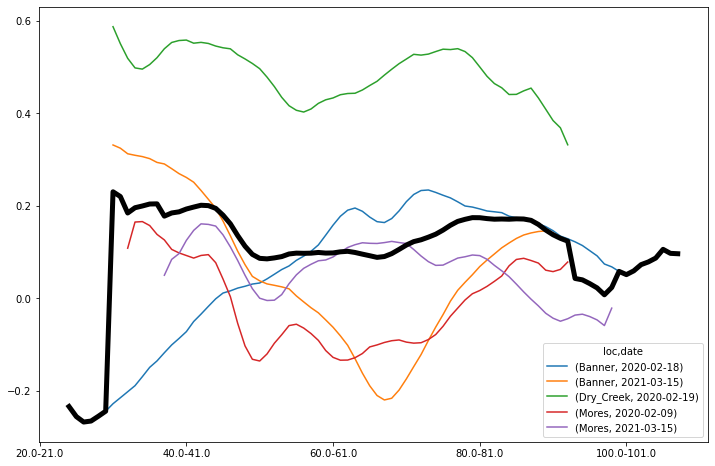

In [38]:
import numpy as np
import pandas as pd
import xarray as xr
import rioxarray as rxa
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
from stats import get_stats, clean_xs_ys

df = pd.read_csv('../../results/lidar/inc.csv', index_col=['stat', 'loc','date'])
sub = df[df.loc[('n')] > 1000]
# sub = sub.T/sub.max(axis = 1)
sub = sub.T
fig, ax = plt.subplots(figsize = (12,8))
sub.T.loc[('r')].T.rolling(5).mean().plot(ax = ax)
sub.T.loc[('r')].T.rolling(5).mean().mean(axis = 1).plot(ax = ax, color = 'black', linewidth = 5)